# Fundamentals of Risk and Returns

In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import analysis_toolkit as at

# The autoreload extension automatically updates for any changes that are made in the modules being imported
# % signifies a magic command
# mode 2 reloads anything that changes
%load_ext autoreload
%autoreload 2

There may be a difference between the **total return** and the **price return** due to the contribution of dividends. Most stock market index portfolios will contain stocks that generate dividends from time to time. Therefore, total returns over a period will almost always exceed the price returns. Methods to calculate percentage change in price:
- Manually calculate using indexing. `pandas` aligns any operations being done by index. `.values` for either one of the columns fixes this
- `.shift(1)`
- `.pct_change()`

## Volatility and Risk
Average of the **squared deviations from the mean** is called variance and calculated as follows:$$\sigma^2_R=\frac{1}{N}\sum^N_{i=1}(R_i-\bar{R})^2$$
Variance cannot be used to assess prices as the units are squared which makes it hard to compare with the returns themselves. For this reason, we take the square root of variance i.e., the standard deviation which we refer to as volatility:$$\sigma_R=\sqrt{\frac{1}{N}\sum^N_{i=1}(R_i-\bar{R})^2}$$
Volatility from daily data cannot be compared with the volatility from monthly data:$$\sigma_{ann}=\sigma_p\sqrt{p}$$
Another **risk-adjusted measure** which looks at the excess return over the risk-free rate (risk premium):$$Sharpe\;Ratio(P)=\frac{R_p-R_f}{\sigma_p}$$

`.std()` calculates sample standard deviation (uses `n-1` as the denominator) 

## Maximum Drawdown
The maximum drawdown is the **maximum loss sustained from the previous high to a subsequent low**.
1. Construct a wealth index; a hypothetical buy-and-hold investment in the asset.
2. Look at the prior peak at any point in time. We can plot the drawdowns over time to be able to see how long it takes to recover from the drawdowns.
3. Compute drawdown - which is the wealth value as a percentage of the previous peak

Drawdowns are entirely defined by two points and hence are very **sensitive to outliers**. They also depend on the frequency of observations. In general, a very deep drawdown on a daily or weekly basis might almost completely disappear or move to very different location based on monthly data.

In [15]:
# parse_dates tells pandas to parse date values as best as it can
# na_values tells pandas what the encoding for NaN values is in the file
df = pd.read_csv("data/Portfolios_Formed_on_ME_monthly_EW.csv", index_col=0, header=0, parse_dates=True,
                 date_format="%Y%m", na_values=-99.99)

# Converts a DateTime Series to a Period series 
df.index = df.index.to_period("M")

# Select the top and bottom deciles (sorted by marketcap)
df = df[["Lo 10", "Hi 10"]]
df.columns = ["SmallCap", "LargeCap"]
df = df/100
df

,SmallCap,LargeCap
1926-07,-0.0145,0.0329
1926-08,0.0512,0.0370
1926-09,0.0093,0.0067
1926-10,-0.0484,-0.0243
1926-11,-0.0078,0.0270
...,...,...
2018-08,0.0241,0.0234
2018-09,-0.0168,0.0087
2018-10,-0.1002,-0.0657
2018-11,-0.0365,0.0253


<Axes: >

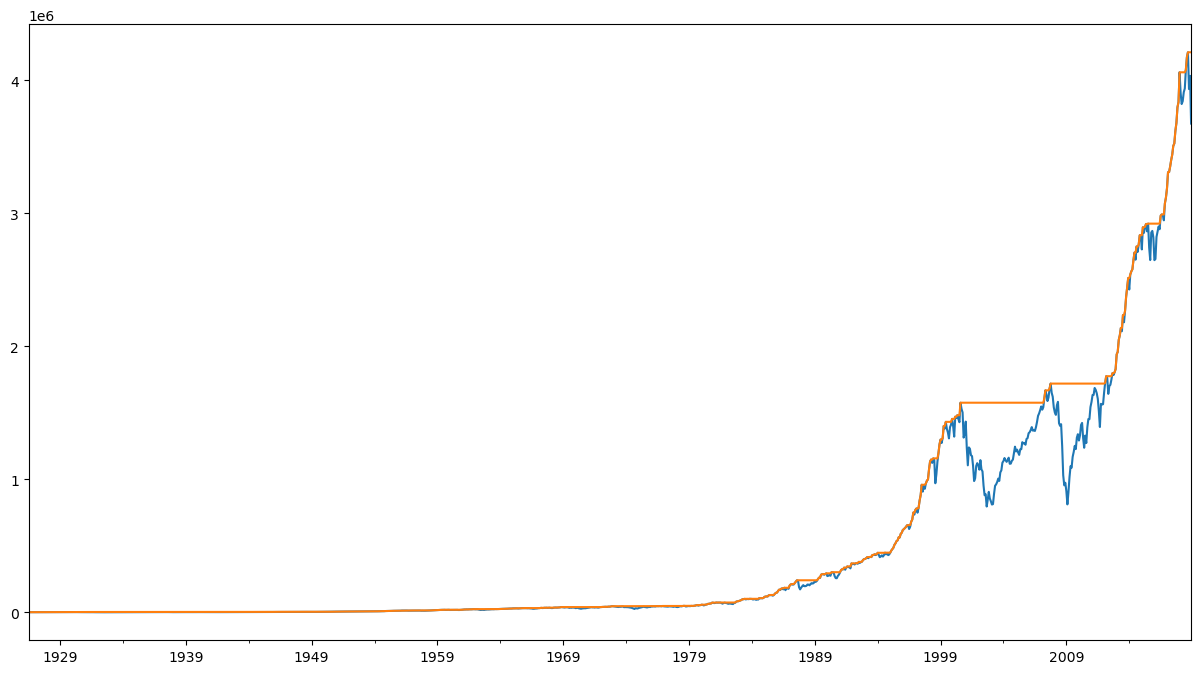

In [17]:
# .cumprod() accounts for compounding every period (cumulative compounding shown)
# buy-and-hold strategy
wealth_index = 1000 * (1 + df["LargeCap"]).cumprod()

# .cummax() keeps track of maximum points
previous_peaks = wealth_index.cummax()

# Plot overlapping time series charts
plt.figure(1, figsize=(15, 8))
wealth_index.plot()
previous_peaks.plot()

<Axes: >

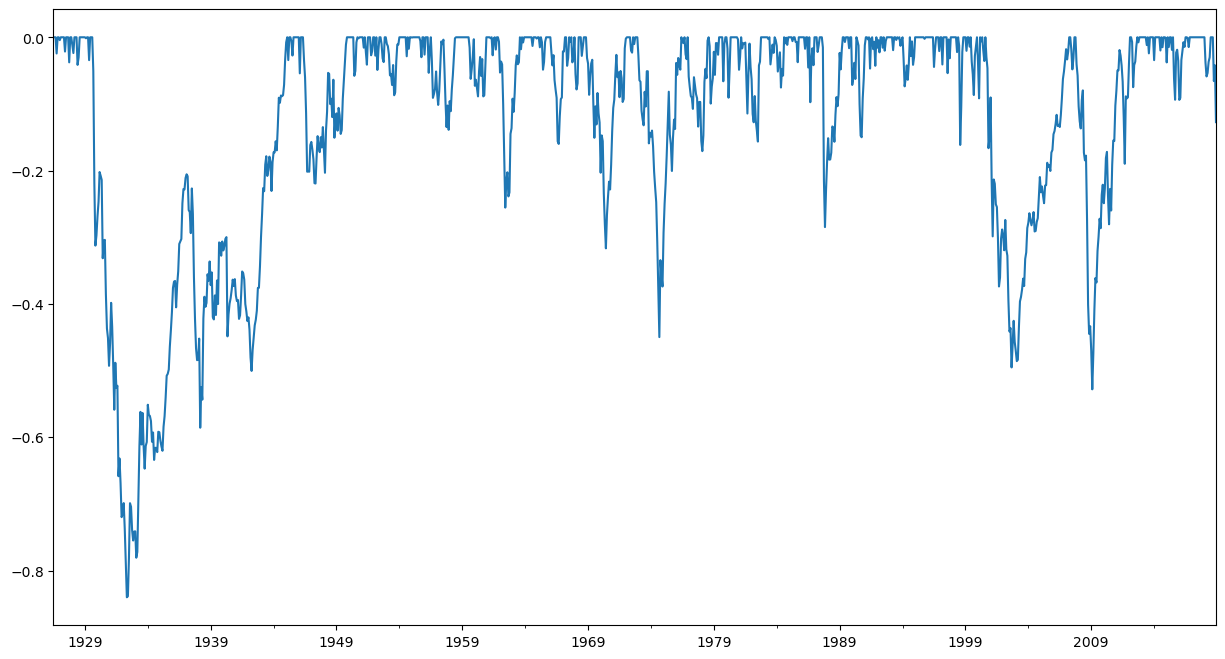

In [19]:
# Calculate drawdown for sample period
drawdown = (wealth_index - previous_peaks) / previous_peaks
plt.figure(2, figsize=(15, 8))
drawdown.plot()

In [21]:
# maximum drawdown since 1975
print(drawdown["1975":].min())

# index of the maximum drawdown since 1975
print(drawdown["1975":].idxmin())

-0.5280945042309304
2009-02


In [25]:
# Calculate drawdown metrics
# Refer to analysis_toolkit.py for function
print(at.drawdown(df["SmallCap"]).head())
print("")
print(at.drawdown(df["SmallCap"]).tail())

              Wealth  Previous Peak  Drawdown
1926-07   985.500000     985.500000  0.000000
1926-08  1035.957600    1035.957600  0.000000
1926-09  1045.592006    1045.592006  0.000000
1926-10   994.985353    1045.592006 -0.048400
1926-11   987.224467    1045.592006 -0.055822

               Wealth  Previous Peak  Drawdown
2018-08  2.298938e+09   2.298938e+09  0.000000
2018-09  2.260316e+09   2.298938e+09 -0.016800
2018-10  2.033832e+09   2.298938e+09 -0.115317
2018-11  1.959597e+09   2.298938e+09 -0.147608
2018-12  1.659583e+09   2.298938e+09 -0.278109


In [27]:
print(at.drawdown(df["SmallCap"]).min())
print("")
print(at.drawdown(df["SmallCap"]).idxmin())

Wealth           491.240323
Previous Peak    985.500000
Drawdown          -0.833001
dtype: float64

Wealth           1932-05
Previous Peak    1926-07
Drawdown         1932-05
dtype: period[M]


The **Calmar Ratio** is the ratio of the annualized return over the trailing 36 months to the maximum drawdown over those trailing 36 months. It is particularly useful for investors who are concerned with downside risk and want to compare investments based on their ability to generate returns without experiencing significant losses.

The **Sortino Ratio** is a variation of the Sharpe Ratio that measures the risk-adjusted return of an investment while focusing on downside risk rather than total volatility. It helps investors distinguish between harmful volatility (downside risk) and overall volatility, providing a more accurate picture of an investment’s risk-adjusted performance: $$\text{Sortino Ratio}=\frac{\text{Annualized Return} − \text{Riskfree Rate}}{\text{Downside Deviation}}$$
To calculate **Downside Deviation**, identify the returns that fall below the minimum acceptable return (MAR) or target return, compute their deviations from MAR, and find the standard deviation of these deviations.

## Beyond the Gaussian Case: Extreme Risk Estimates
When analyzing the return distribution of an investment, moving beyond the mean (average return) and variance (a measure of volatility) allows for a more nuanced understanding of the potential risks and behaviors of investment returns.

- **First moment (Mean):** This is the average value of the distribution and gives you a sense of the central tendency. $\mu=E[x]=\frac{1}{N}\sum^N_{i=1}x_i$.
- **Second moment (Variance):** This measures the dispersion of the distribution around the mean, essentially quantifying risk in terms of variability. $\sigma^2=Var(X)=\frac{1}{N-1}\sum^N_{i=1}(x_i-\mu)^2$.
- **Third moment (Skewness):** This measures the asymmetry of the distribution. A positive skew means that there's a long tail in the positive direction, suggesting higher positive returns. Negative skew indicates a long tail in the negative direction, suggesting a risk of significant losses. $\gamma=E[(\frac{X-\mu}{\sigma})^3]=\frac{1}{N}\sum^N_{i=1}(\frac{x_i-\mu}{\sigma})^3$.
- **Fourth moment (Kurtosis):** This measures the "tailedness" of the distribution. High kurtosis means that extreme values (both high and low) are more likely than they would be in a normal distribution (which has a kurtosis of 3, known as mesokurtic). A distribution with high kurtosis (leptokurtic) has fat tails and a sharp peak, indicating a high risk of outlier events, which is essential information in risk management. $\kappa=E[(\frac{X-\mu}{\sigma})^4]=\frac{1}{N}\sum^N_{i=1}(\frac{x_i-\mu}{\sigma})^4$.

These formulas assume that you are working with a sample of data. For population parameters, the formulas are slightly different, primarily in the variance and standard deviation calculations where you would use $N$ instead of $N−1$. Also, it is important to note that these moments are based on the assumption that the **underlying distribution of returns is stationary and the moments are constant over time**, which is not always the case in financial markets.

In [40]:
# Load hedge fund index returns
hfi = at.get_hfi_returns()
hfi.head()

,Convertible Arbitrage,CTA Global,Distressed Securities,Emerging Markets,Equity Market Neutral,Event Driven,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Merger Arbitrage,Relative Value,Short Selling,Funds Of Funds
date,,,,,,,,,,,,,
1997-01,0.0119,0.0393,0.0178,0.0791,0.0189,0.0213,0.0191,0.0573,0.0281,0.0150,0.0180,-0.0166,0.0317
1997-02,0.0123,0.0298,0.0122,0.0525,0.0101,0.0084,0.0122,0.0175,-0.0006,0.0034,0.0118,0.0426,0.0106
1997-03,0.0078,-0.0021,-0.0012,-0.0120,0.0016,-0.0023,0.0109,-0.0119,-0.0084,0.0060,0.0010,0.0778,-0.0077
1997-04,0.0086,-0.0170,0.0030,0.0119,0.0119,-0.0005,0.0130,0.0172,0.0084,-0.0001,0.0122,-0.0129,0.0009
1997-05,0.0156,-0.0015,0.0233,0.0315,0.0189,0.0346,0.0118,0.0108,0.0394,0.0197,0.0173,-0.0737,0.0275


In [26]:
# Concatenating columns required for skewness and kurtosis
pd.concat([hfi.mean(), hfi.median(), hfi.mean() > hfi.median()], axis=1)

,0,1,2
Convertible Arbitrage,0.005508,0.0065,False
CTA Global,0.004074,0.0014,True
Distressed Securities,0.006946,0.0089,False
Emerging Markets,0.006253,0.0096,False
Equity Market Neutral,0.004498,0.0051,False
Event Driven,0.006344,0.0084,False
Fixed Income Arbitrage,0.004365,0.0055,False
Global Macro,0.005403,0.0038,True
Long/Short Equity,0.006331,0.0079,False
Merger Arbitrage,0.005356,0.0060,False


### Skewness
In a normal distribution **(zero skewness)**, the mean, median, and mode are all equal. The probability of an outcome below the mean is 50%, and the probability of an outcome above the mean is also 50%.
With **negative skewness**, the mean is lower than the median. **Since the mean is pulled to the left, more data points lie above the mean than below it. Therefore, the probability of an outcome above the mean is higher than the probability of an outcome below the mean.**
- For normally distributed returns, volatility effectively captures the risk. However, in negatively skewed distributions, volatility may underestimate the risk of extreme negative returns (tail risk). Negative skewness implies a higher likelihood of extreme negative outcomes that are not fully captured by volatility alone.

In [42]:
# scipy.stats.skew() can also be used
at.skewness(hfi).sort_values()

Fixed Income Arbitrage   -3.940320
Convertible Arbitrage    -2.639592
Equity Market Neutral    -2.124435
Relative Value           -1.815470
Event Driven             -1.409154
Merger Arbitrage         -1.320083
Distressed Securities    -1.300842
Emerging Markets         -1.167067
Long/Short Equity        -0.390227
Funds Of Funds           -0.361783
CTA Global                0.173699
Short Selling             0.767975
Global Macro              0.982922
dtype: float64

### Kurtosis

In [44]:
# scipy.stats.kurtosis() returns the excess kurtosis i.e., all values below are lower by 3
at.kurtosis(hfi).sort_values()

CTA Global                 2.952960
Long/Short Equity          4.523893
Global Macro               5.741679
Short Selling              6.117772
Funds Of Funds             7.070153
Distressed Securities      7.889983
Event Driven               8.035828
Merger Arbitrage           8.738950
Emerging Markets           9.250788
Relative Value            12.121208
Equity Market Neutral     17.218555
Convertible Arbitrage     23.280834
Fixed Income Arbitrage    29.842199
dtype: float64

## Jarque-Bera Test for Normality
The **Jarque-Bera** test is a statistical test that is used to **determine whether a series of numbers has the skewness and kurtosis matching a normal distribution**. The test's null hypothesis is that the data are normally distributed, and any deviation from this increases the test statistic:$$JB=\frac{n}{6}(S^2+\frac{1}{4}(K-3)^2)$$ where:
- $n$ is the number of observations in the data series.
- $S$ is the sample skewness.
- $K$ is the sample kurtosis.

The test statistic JB follows a chi-squared distribution with two degrees of freedom for large $n$. When the JB statistic is large, it indicates that the data do not follow a normal distribution. The null hypothesis of normality is rejected if the JB statistic is too large. The rejection of the null hypothesis suggests that the data may have a skewness and/or kurtosis that deviates significantly from that of a normal distribution, which could invalidate analyses that assume normality (like many parametric statistical tests).

**It is important to note that the Jarque-Bera test can be sensitive to the sample size. Very large samples can result in the rejection of the null hypothesis even when the deviation from normality is negligible for practical purposes. Conversely, with small samples, the test may not have enough power to detect departures from normality.**

## Probability and Expected Occurences
When dealing with rare events, the reciprocal of the probability tells us how often, on average, the event is expected to occur. For example, if an event has a probability of 1%, it means that, on average, the event will occur once in every 100 trials $\frac{1}{0.01}=100$. The reciprocal of the probability $\frac{1}{P}$ represents the expected number of trials needed to observe one occurrence of the event. It stems from the idea that if an event has a probability $P$, then on average, it will happen once every $\frac{1}{P}$ trials.

In [46]:
# scipy.stats.jarque_bera() cannot compute results for individual indices
# .aggregate() on a DataFrame takes a function as an argument and applies that function to each column
at.is_normal(hfi)

Convertible Arbitrage     False
CTA Global                 True
Distressed Securities     False
Emerging Markets          False
Equity Market Neutral     False
Event Driven              False
Fixed Income Arbitrage    False
Global Macro              False
Long/Short Equity         False
Merger Arbitrage          False
Relative Value            False
Short Selling             False
Funds Of Funds            False
dtype: bool

## Semi-Deviation
Volatility of the sub-sample of **below-average or below-zero returns**:$$\sigma_{semi}=\sqrt{\frac{1}{N}\sum_{R_t\le\bar{R}}(R_t-\bar{R})^2}$$
where $N$ is the number of returns that fall below the mean.

In [48]:
# Semi-deviation is the volatility of the subset of returns that are negative
at.semideviation(hfi)

Convertible Arbitrage     0.019540
CTA Global                0.012443
Distressed Securities     0.015185
Emerging Markets          0.028039
Equity Market Neutral     0.009566
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Global Macro              0.006579
Long/Short Equity         0.014051
Merger Arbitrage          0.008875
Relative Value            0.012244
Short Selling             0.027283
Funds Of Funds            0.012122
dtype: float64

## VaR and CVaR
If an investor looks only at the mean and volatility, they might not fully appreciate the risk of extreme negative outcomes (tail risk). In such cases, they could underestimate the likelihood and potential impact of significant losses. To account for this, additional risk measures such as **Value at Risk (VaR)**, **Conditional Value at Risk (CVaR)**, and stress testing scenarios can be used alongside skewness and kurtosis to provide a more comprehensive risk assessment.

### Historic VaR
To compute the historic VaR at a certain level, say 5%, all we have to do is to find the number such that 5% of the returns fall below that number and 95% of the returns fall above that number. In other words, we want the 5th percentile return. Note that for reporting purposes, it is common to invert the sign so we report a positive number to represent the loss i.e., the amount that is at risk.

The drawback is because you are solely relying on historical data, your estimate might be pretty **sensitive to the sample period**. If you change the sample period a little bit then, you might find vastly different estimates for VaR.

In [50]:
at.var_historic(hfi, level=1)

Convertible Arbitrage     0.031776
CTA Global                0.049542
Distressed Securities     0.046654
Emerging Markets          0.088466
Equity Market Neutral     0.018000
Event Driven              0.048612
Fixed Income Arbitrage    0.041672
Global Macro              0.024316
Long/Short Equity         0.049558
Merger Arbitrage          0.025336
Relative Value            0.026660
Short Selling             0.113576
Funds Of Funds            0.039664
dtype: float64

### Conditional VaR (Expected Shortfall)

In [52]:
# Conditional VaR is the mean of the numbers that fall below the VaR
at.cvar_historic(hfi)

Convertible Arbitrage     0.036550
CTA Global                0.041264
Distressed Securities     0.036429
Emerging Markets          0.072364
Equity Market Neutral     0.016879
Event Driven              0.038336
Fixed Income Arbitrage    0.028257
Global Macro              0.020629
Long/Short Equity         0.041943
Merger Arbitrage          0.019143
Relative Value            0.024650
Short Selling             0.096821
Funds Of Funds            0.033207
dtype: float64

### Parametric Gaussian VaR
A **parametric approach** in statistics refers to methods that make **assumptions about the underlying distribution of the data**. In the context of risk management and the calculation of Value at Risk (VaR), a parametric approach assumes that the returns of a financial asset or portfolio follow a specific probability distribution, typically a normal distribution due to its mathematical convenience. You only need to estimate the mean and volatility of the distribution. The problem when using a parametric assumption is the risk of specifying a wrong model called a **specification risk**.

Consider $Z_\alpha$ the $\alpha$-quantile of the standard normal distribution. For example $Z_\alpha=-1.65$ at 5% (actually 4.95%).$$VaR_\alpha=-(\mu+z_\alpha\sigma)$$

In [54]:
at.var_gaussian(hfi)

Convertible Arbitrage     0.021691
CTA Global                0.034235
Distressed Securities     0.021032
Emerging Markets          0.047164
Equity Market Neutral     0.008850
Event Driven              0.021144
Fixed Income Arbitrage    0.014579
Global Macro              0.018766
Long/Short Equity         0.026397
Merger Arbitrage          0.010435
Relative Value            0.013061
Short Selling             0.080086
Funds Of Funds            0.021292
dtype: float64

### Cornish-Fisher Modification

Cornish-Fisher expansion relates the $\alpha$ quantile of non Gaussian distribution to the $\alpha$ quantile of the Gaussian distribution. **If the skewness goes to zero, and if the kurtosis is equal to three, then we go back to $z_\alpha$ of the Gaussian distribution and in this case, we find the same value at risk estimate as when we are using the Gaussian distribution.**
- If the skewness is negative, and the kurtosis is higher than three, this adjustment will give a VaR estimate that will be higher than the Gaussian estimate. This means that there is a higher probability or a higher chance of a negative outcome.
- If the observed skewness is positive, as is the case for "Short Selling", and "Global Macro", the VaR is lower i.e., estimates a smaller loss than you would get from a pure Gaussian assumption.
$$z_{cornishfisher} = z +\frac{1}{6}(z^2-1)S + \frac{1}{24}(z^3-3z)(K-3)-\frac{1}{36}(2z^3-5z)S^2$$

<Axes: title={'center': 'Hedge Fund Indices: VaR at 5%'}>

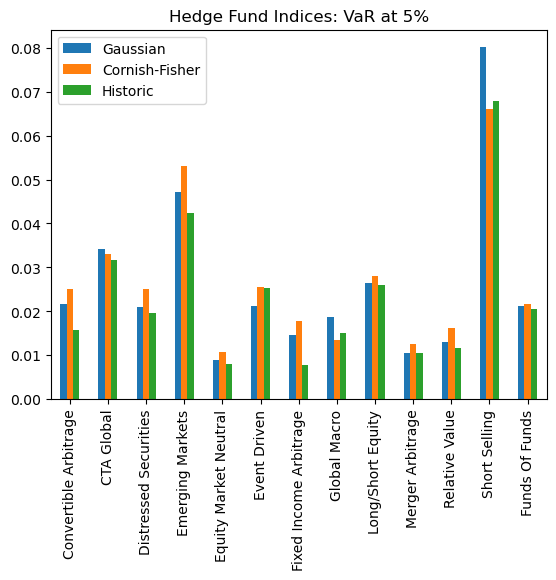

In [56]:
var_table = [at.var_gaussian(hfi), at.var_gaussian(hfi, modified=True), at.var_historic(hfi)]
comparison = pd.concat(var_table, axis=1)
comparison.columns=["Gaussian", "Cornish-Fisher", "Historic"]
comparison.plot.bar(title="Hedge Fund Indices: VaR at 5%")

In [58]:
at.skewness(hfi).sort_values(ascending=False)

Global Macro              0.982922
Short Selling             0.767975
CTA Global                0.173699
Funds Of Funds           -0.361783
Long/Short Equity        -0.390227
Emerging Markets         -1.167067
Distressed Securities    -1.300842
Merger Arbitrage         -1.320083
Event Driven             -1.409154
Relative Value           -1.815470
Equity Market Neutral    -2.124435
Convertible Arbitrage    -2.639592
Fixed Income Arbitrage   -3.940320
dtype: float64

There are many different methods that can be used to estimate VaR. It is a trade off between sample risk and model risk.

An important aspect of financial returns is **time-series correlation**, also known as **autocorrelation**. Asset returns can exhibit various forms of autocorrelation, where past returns can influence future returns, at least in the short term. This violates one of the assumptions of a normal distribution, which is that the observations are independent and identically distributed (i.i.d.).

The frequency of observation also plays a significant role in the behavior of asset returns:
- **High-Frequency Data:** When observing asset returns at a high frequency (e.g., minute-by-minute, hourly), you may encounter more non-normal characteristics. This can be due to market microstructure noise, bid-ask bounce, and intraday patterns, such as higher volatility at market open and close. At such granular levels, returns can exhibit jumps, fat tails, and significant skewness, deviating from normality.

- **Daily and Lower Frequency Data:** When returns are observed at lower frequencies (e.g., daily, weekly, monthly), some of the microstructure noise is averaged out, and returns may appear more normally distributed due to the central limit theorem. However, even at these frequencies, notable events or the accumulation of small shocks can lead to outliers that contribute to skewness and kurtosis.

**Aggregated Returns:** When returns are aggregated over longer periods, they might tend to normality if the individual price changes are independent and identically distributed, as per the central limit theorem. However, due to structural changes, trends, cycles, and other economic factors, the i.i.d. assumption often does not hold in practice.

It is also important to note that financial markets are influenced by human behavior, which can result in herding effects, overreactions, and other phenomena that cause asset returns to deviate from normality. Given these complexities, when modeling asset returns or assessing risk, it is prudent to consider models that accommodate skewness, kurtosis, and autocorrelation. For example, **GARCH (Generalized Autoregressive Conditional Heteroskedasticity)** models can capture time-varying volatility clustering, and **Extreme Value Theory** can be used to model the tails of the distribution more accurately.